In [10]:
# IMPORTANDO BIBLIOTECAS
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from pickle import load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
"""
## 1. Carregando Modelos e Pré-processadores
"""
# Carregando os modelos treinados
diagnosis_model = load(open('../models/modeloDiagnosis.pkl', 'rb'))
severity_model = load(open('../models/modeloSeverity.pkl', 'rb'))
management_model = load(open('../models/modeloManagement.pkl', 'rb'))
normalizador = load(open('../models/modelo_normalizador_num.pkl', 'rb'))

In [12]:
"""
## 2. Funções para Processamento de Novos Dados
"""
def preparar_novos_dados(novos_dados):
    """
    Pré-processa novos dados da mesma forma que foi feito no treinamento
    """
    # Listas de colunas esperadas (devem ser iguais às do treinamento)
    binary_columns = {
        'Appendix_on_US', 'Migratory_Pain', 'Lower_Right_Abd_Pain', 
        'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea',
        'Loss_of_Appetite', 'Neutrophilia', 'Dysuria', 'Psoas_Sign',
        'Ipsilateral_Rebound_Tenderness', 'US_Performed', 'Free_Fluids'
    }
    
    categorical_cols = ['Sex', 'Ketones_in_Urine', 'RBC_in_Urine', 
                      'WBC_in_Urine', 'Stool', 'Peritonitis']
    
    numerical_cols = [
        'Age', 'BMI', 'Height', 'Weight', 'Length_of_Stay', 'Appendix_Diameter',
        'Body_Temperature', 'WBC_Count', 'Neutrophil_Percentage', 'RBC_Count',
        'Hemoglobin', 'RDW', 'Thrombocyte_Count', 'CRP'
    ]
    
    # Converter colunas binárias
    for col in binary_columns:
        if col in novos_dados.columns:
            novos_dados[col] = novos_dados[col].map({'yes': 1, 'no': 0})
    
    # Normalizar colunas numéricas
    novos_dados[numerical_cols] = normalizador.transform(novos_dados[numerical_cols])
    
    # One-Hot Encoding para colunas categóricas
    novos_dados = pd.get_dummies(novos_dados, columns=categorical_cols, drop_first=True)
    
    return novos_dados


In [13]:
"""
## 3. Avaliação dos Modelos em Dados de Teste
"""
# Carregando os dados processados
df_processed = pd.read_csv('../data/df_normalizado.csv')

# Separando em features e targets
X = df_processed.drop(columns=['Diagnosis', 'Severity', 'Management'], errors='ignore')
y_diagnosis = df_processed['Diagnosis']
y_severity = df_processed[df_processed['Diagnosis'] == 'appendicitis']['Severity']
y_management = df_processed[df_processed['Diagnosis'] == 'appendicitis']['Management']

# Dividindo os dados (usando os mesmos random_state para consistência)
X_train, X_test, y_diagnosis_train, y_diagnosis_test = train_test_split(
    X, y_diagnosis, test_size=0.2, random_state=42)


=== Relatório de Classificação (Diagnóstico) ===
                 precision    recall  f1-score   support

   appendicitis       0.99      0.97      0.98        95
no appendicitis       0.95      0.98      0.97        62

       accuracy                           0.97       157
      macro avg       0.97      0.98      0.97       157
   weighted avg       0.97      0.97      0.97       157



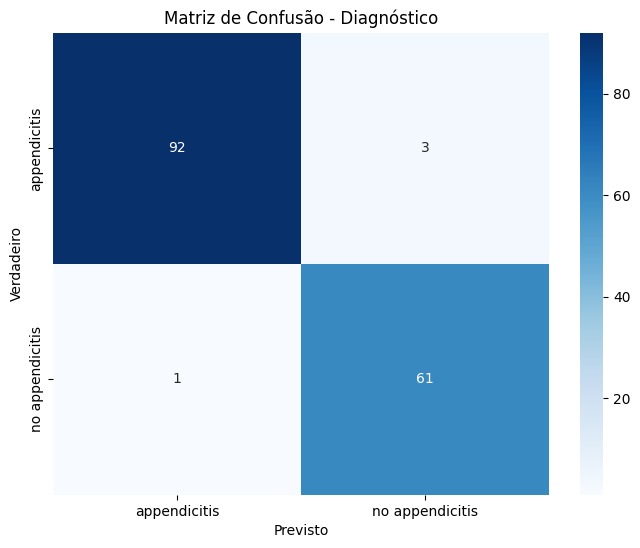

In [14]:
"""
### 3.1. Avaliação do Modelo de Diagnóstico
"""
# Fazendo previsões
y_diagnosis_pred = diagnosis_model.predict(X_test)

# Métricas de avaliação
print("\n=== Relatório de Classificação (Diagnóstico) ===")
print(classification_report(y_diagnosis_test, y_diagnosis_pred))

# Matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_diagnosis_test, y_diagnosis_pred), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=diagnosis_model.classes_, 
            yticklabels=diagnosis_model.classes_)
plt.title("Matriz de Confusão - Diagnóstico")
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()


=== Relatório de Classificação (Severidade) ===
               precision    recall  f1-score   support

  complicated       0.76      0.54      0.63        24
uncomplicated       0.86      0.94      0.90        71

     accuracy                           0.84        95
    macro avg       0.81      0.74      0.77        95
 weighted avg       0.84      0.84      0.83        95



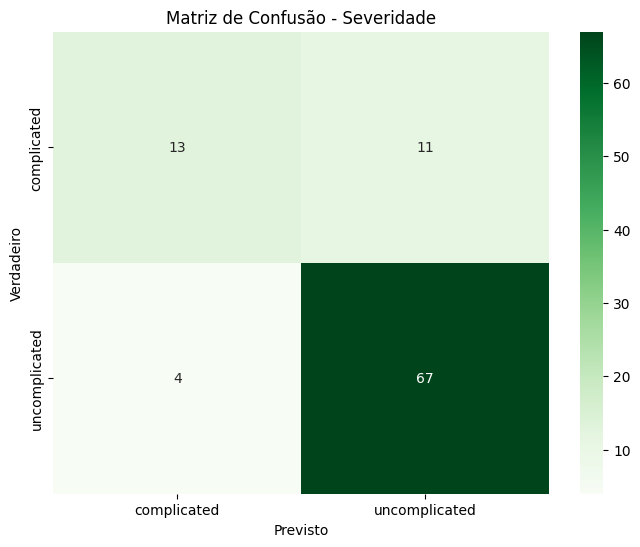

In [15]:
"""
### 3.2. Avaliação do Modelo de Severidade (apenas para apendicite confirmado)
"""
# Filtrando apenas casos de apendicite no teste
apendicite_mask = y_diagnosis_test == 'appendicitis'
X_test_severity = X_test[apendicite_mask]
y_severity_test = y_severity.loc[X_test_severity.index]

# Fazendo previsões
y_severity_pred = severity_model.predict(X_test_severity)

# Métricas de avaliação
print("\n=== Relatório de Classificação (Severidade) ===")
print(classification_report(y_severity_test, y_severity_pred))

# Matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_severity_test, y_severity_pred), 
            annot=True, fmt='d', cmap='Greens',
            xticklabels=severity_model.classes_, 
            yticklabels=severity_model.classes_)
plt.title("Matriz de Confusão - Severidade")
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()


=== Relatório de Classificação (Tratamento) ===
                    precision    recall  f1-score   support

      conservative       0.90      1.00      0.95        35
  primary surgical       0.95      0.95      0.95        55
secondary surgical       1.00      0.20      0.33         5

          accuracy                           0.93        95
         macro avg       0.95      0.72      0.74        95
      weighted avg       0.93      0.93      0.91        95



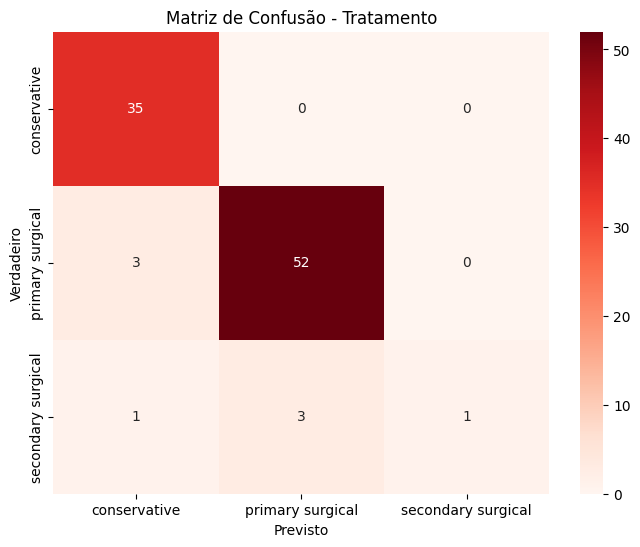

In [16]:
"""
### 3.3. Avaliação do Modelo de Tratamento (apenas para apendicite confirmado)
"""
# Usando o mesmo filtro de apendicite
X_test_management = X_test[apendicite_mask]
y_management_test = y_management.loc[X_test_management.index]

# Fazendo previsões
y_management_pred = management_model.predict(X_test_management)

# Métricas de avaliação
print("\n=== Relatório de Classificação (Tratamento) ===")
print(classification_report(y_management_test, y_management_pred))

# Matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_management_test, y_management_pred), 
            annot=True, fmt='d', cmap='Reds',
            xticklabels=management_model.classes_, 
            yticklabels=management_model.classes_)
plt.title("Matriz de Confusão - Tratamento")
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

In [17]:
"""
## 4. Sistema de Inferência para Novos Casos

Vamos criar uma função para simular a avaliação de um novo paciente
"""
def avaliar_paciente(paciente):
    # Carregar modelos
    diagnosis_model = load(open('../models/modeloDiagnosis.pkl', 'rb'))
    normalizador = load(open('../models/modelo_normalizador_num.pkl', 'rb'))
    
    # Obter features esperadas pelo modelo
    expected_features = diagnosis_model.feature_names_in_
    numerical_features = normalizador.feature_names_in_
    
    # Criar DataFrame com todas features esperadas
    dados_paciente = pd.DataFrame(columns=expected_features)
    
    # Primeiro preencher as features categóricas/binárias
    binary_features = ['Appendix_on_US', 'Migratory_Pain', 'Lower_Right_Abd_Pain',
                     'Nausea', 'Loss_of_Appetite', 'US_Performed', 'Free_Fluids']
    
    for feature in binary_features:
        dados_paciente[feature] = [1 if paciente.get(feature, 'no') == 'yes' else 0]
    
    # Preencher features categóricas one-hot
    categorical_mapping = {
        'Sex': {'male': 1, 'female': 0},
        'Ketones_in_Urine': {'no': 0, 'trace': 1, '+': 1, '++': 1, '+++': 1},
        'RBC_in_Urine': {'no': 0, 'yes': 1},
        'WBC_in_Urine': {'no': 0, 'yes': 1},
        'Stool': {'normal': 1, 'soft': 0, 'hard': 0},
        'Peritonitis': {'no': 0, 'yes': 1}
    }
    
    for base_feature, mapping in categorical_mapping.items():
        value = paciente.get(base_feature, 'no')
        for feature in expected_features:
            if feature.startswith(base_feature):
                category = feature.split('_')[-1]
                dados_paciente[feature] = [1 if str(value).lower() == category.lower() else 0]
    
    # Preencher features numéricas com valores padrão se necessário
    numerical_defaults = {
        'Length_of_Stay': 2,
        'Appendix_Diameter': 7.0,
        'RBC_Count': 4.5,
        'Hemoglobin': 12.0,
        'RDW': 13.0,
        'Thrombocyte_Count': 250
    }
    
    for feature in numerical_features:
        if feature in paciente:
            dados_paciente[feature] = [paciente[feature]]
        else:
            dados_paciente[feature] = [numerical_defaults.get(feature, 0)]
    
    # Verificar se todas as colunas numéricas foram preenchidas
    missing_numerical = [f for f in numerical_features if f not in dados_paciente]
    if missing_numerical:
        print(f"Aviso: Preenchendo automaticamente features numéricas faltantes: {missing_numerical}")
        for feature in missing_numerical:
            dados_paciente[feature] = [numerical_defaults.get(feature, 0)]
    
    # Aplicar normalização apenas nas colunas numéricas esperadas
    try:
        dados_paciente[numerical_features] = normalizador.transform(dados_paciente[numerical_features])
    except ValueError as e:
        print("Erro na normalização. Verificando dados...")
        print("Features numéricas esperadas:", numerical_features)
        print("Features disponíveis:", dados_paciente.columns)
        print("Valores NaN:", dados_paciente.isnull().sum())
        raise
    
    # Garantir a ordem correta das colunas
    dados_paciente = dados_paciente[expected_features]
    
    # Fazer previsões
    diagnostico = diagnosis_model.predict(dados_paciente)[0]
    
    resultado = {
        'Diagnóstico': diagnostico,
        'Severidade': None,
        'Tratamento Recomendado': None
    }
    
    if diagnostico == 'appendicitis':
        severity_model = load(open('../models/modeloSeverity.pkl', 'rb'))
        management_model = load(open('../models/modeloManagement.pkl', 'rb'))
        
        resultado['Severidade'] = severity_model.predict(dados_paciente)[0]
        resultado['Tratamento Recomendado'] = management_model.predict(dados_paciente)[0]
    
    return resultado

In [18]:
"""
## 5. Simulação de Casos Reais

Vamos testar com alguns casos exemplares
"""
# Caso 1: Criança com alta probabilidade de apendicite
caso1 = {
    'Age': 10,
    'Sex': 'male',
    'BMI': 18.5,
    'Height': 140,
    'Weight': 36,
    'Appendix_on_US': 'yes',       
    'Migratory_Pain': 'yes',         
    'Lower_Right_Abd_Pain': 'yes',   
    'Body_Temperature': 38.2,       
    'WBC_Count': 15000,              
    'Neutrophil_Percentage': 85,      
    'CRP': 45,                        
    'Nausea': 'yes',                 
    'Loss_of_Appetite': 'yes',      
    'US_Performed': 'yes',            
    'Free_Fluids': 'yes',             
    'Ketones_in_Urine': 'no',        
    'RBC_in_Urine': 'no',             
    'WBC_in_Urine': 'no',             
    'Stool': 'normal',                
    'Peritonitis': 'no',
    'Length_of_Stay': 3,              
    'Appendix_Diameter': 9.0,        
    'RBC_Count': 4.5,                  
    'Hemoglobin': 12.5,                
    'RDW': 13.0,                      
    'Thrombocyte_Count': 300           
}

# Caso 2: Criança com sintomas pouco claros
caso2 = {
    'Age': 8,
    'Sex': 'female',
    'BMI': 16.8,
    'Height': 130,
    'Weight': 28,
    'Appendix_on_US': 'no',
    'Migratory_Pain': 'no',
    'Lower_Right_Abd_Pain': 'yes',
    'Body_Temperature': 37.5,
    'WBC_Count': 11000,
    'Neutrophil_Percentage': 70,
    'CRP': 12,
    'Nausea': 'yes',
    'Loss_of_Appetite': 'no',
    'US_Performed': 'yes',
    'Free_Fluids': 'no',
    'Ketones_in_Urine': 'no',
    'RBC_in_Urine': 'no',
    'WBC_in_Urine': 'no',
    'Stool': 'normal',
    'Peritonitis': 'no',
     'Length_of_Stay': 1,               
    'Appendix_Diameter': 6.0,         
    'RBC_Count': 4.5,                 
    'Hemoglobin': 12.0,                
    'RDW': 13.0,                      
    'Thrombocyte_Count': 250           
}

# Caso 3: Criança saudável
caso3 = {
    'Age': 12,
    'Sex': 'male',
    'BMI': 19.2,
    'Height': 150,
    'Weight': 43,
    'Appendix_on_US': 'no',
    'Migratory_Pain': 'no',
    'Lower_Right_Abd_Pain': 'no',
    'Body_Temperature': 36.8,
    'WBC_Count': 8000,
    'Neutrophil_Percentage': 60,
    'CRP': 5,
    'Nausea': 'no',
    'Loss_of_Appetite': 'no',
    'US_Performed': 'no',
    'Free_Fluids': 'no',
    'Ketones_in_Urine': 'no',
    'RBC_in_Urine': 'no',
    'WBC_in_Urine': 'no',
    'Stool': 'normal',
    'Peritonitis': 'no',
    'Length_of_Stay': 0,            
    'Appendix_Diameter': 5.0,          
    'RBC_Count': 4.7,                 
    'Hemoglobin': 13.5,               
    'RDW': 12.5,                      
    'Thrombocyte_Count': 280           
}

# Avaliando os casos
print("\n=== Resultados para Caso 1 (Sintomas Graves) ===")
display(avaliar_paciente(caso1))

print("\n=== Resultados para Caso 2 (Sintomas Ambíguos) ===")
display(avaliar_paciente(caso2))

print("\n=== Resultados para Caso 3 (Saudável) ===")
display(avaliar_paciente(caso3))



=== Resultados para Caso 1 (Sintomas Graves) ===


{'Diagnóstico': 'appendicitis',
 'Severidade': 'uncomplicated',
 'Tratamento Recomendado': 'conservative'}


=== Resultados para Caso 2 (Sintomas Ambíguos) ===


{'Diagnóstico': 'no appendicitis',
 'Severidade': None,
 'Tratamento Recomendado': None}


=== Resultados para Caso 3 (Saudável) ===


{'Diagnóstico': 'no appendicitis',
 'Severidade': None,
 'Tratamento Recomendado': None}

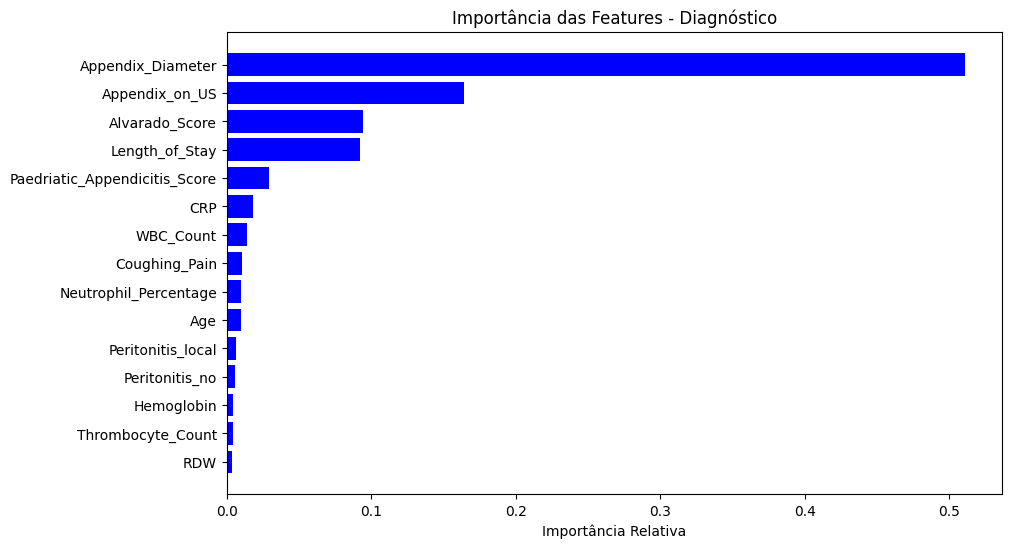

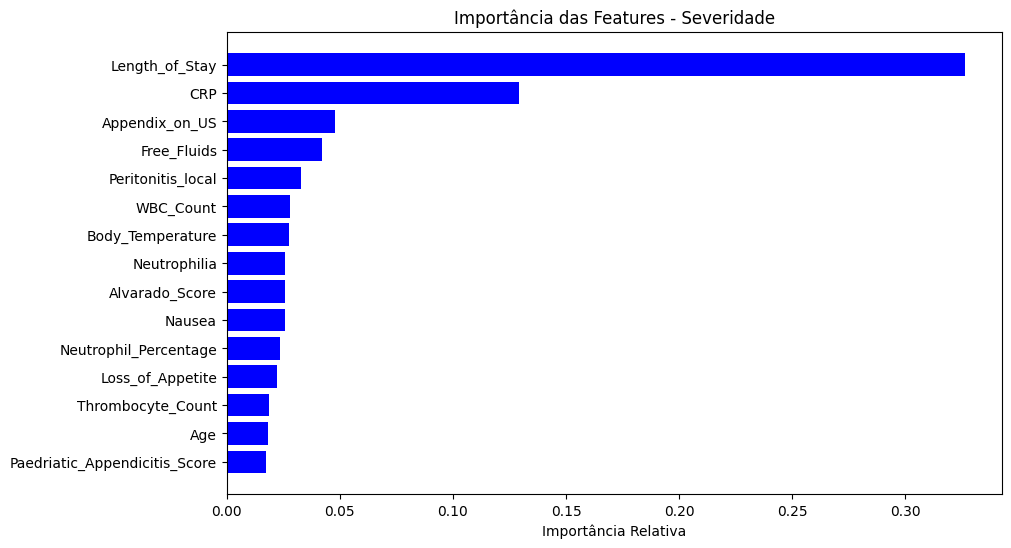

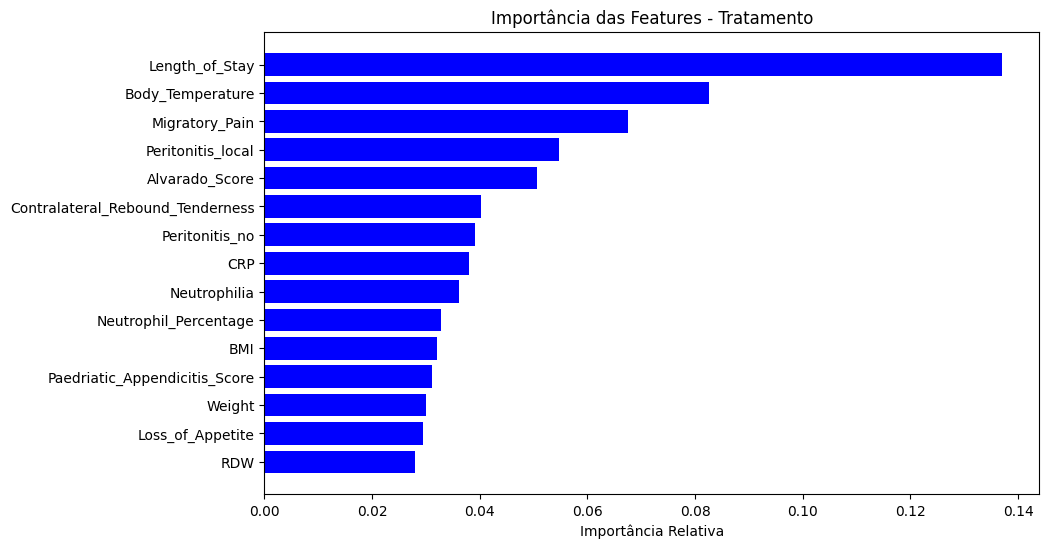

In [19]:
"""
## 6. Análise de Importância das Features
"""
def plot_feature_importance(model, title):
    """Plota a importância das features para um modelo"""
    importances = model.feature_importances_
    indices = np.argsort(importances)[-15:]  # Seleciona as 15 mais importantes
    plt.figure(figsize=(10, 6))
    plt.title(f"Importância das Features - {title}")
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
    plt.xlabel('Importância Relativa')
    plt.show()

# Plotando importância para cada modelo
plot_feature_importance(diagnosis_model, "Diagnóstico")
plot_feature_importance(severity_model, "Severidade")
plot_feature_importance(management_model, "Tratamento")